# **Challenge: Boston marathon**

You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [22]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
import statsmodels.formula.api as smf
%matplotlib inline

In [23]:
df = pd.read_csv('results.csv')
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [24]:
df.describe()

,division,age,official,genderdiv,overall,pace
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,1932.563032,42.407079,242.997314,8051.044741,15939.587825,9.275658
std,1715.228694,11.316496,52.300431,4754.005626,9232.978224,1.992486
min,1.000000,18.000000,80.600000,1.000000,1.000000,3.080000
25%,610.000000,33.000000,205.527500,3972.000000,7943.750000,7.850000
50%,1425.000000,42.000000,232.370000,7970.000000,15939.500000,8.870000
75%,2611.000000,50.000000,273.235000,11968.000000,23935.250000,10.430000
max,6979.000000,81.000000,538.880000,17575.000000,31931.000000,20.570000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [26]:
df = df.drop(['name', 'bib', 'ctz'], axis=1)
df.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,8,47.67,M,47,85.25,8,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,1,82.43,F,33,138.95,1,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,1,45.80,M,41,80.60,1,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,3,82.43,F,24,140.58,3,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,2,46.37,M,40,81.23,2,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [27]:
df.nunique()

10k           2766
division      6979
25k           6570
gender           2
age             64
official     11030
genderdiv    17575
35k           9516
overall      31931
pace           727
state           68
30k           8090
5k            1491
half          5651
20k           5375
country         78
city          5934
40k          10546
dtype: int64

In [28]:
df.isnull().sum()

10k             0
division        0
25k             0
gender          0
age             0
official        0
genderdiv       0
35k             0
overall         0
pace            0
state        2576
30k             0
5k              0
half            0
20k             0
country         0
city            1
40k             0
dtype: int64

In [29]:
df = df.dropna()
df.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
9,30.48,20,77.68,M,31,137.83,20,112.27,20,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83
14,17.12,13,48.88,M,29,87.40,13,72.83,13,3.35,ON,60.82,8.02,40.20,38.02,CAN,Port Elgin,82.38
15,33.93,10,85.03,F,30,143.90,10,119.68,46,5.50,MI,102.40,16.92,71.68,67.92,USA,Rochester Hills,136.47
24,18.30,14,50.33,M,47,89.40,14,74.95,14,3.42,QC,62.33,8.67,41.80,39.63,CAN,St-Jean Baptiste,84.48
27,18.78,15,50.33,M,30,89.52,15,75.02,15,3.42,IL,62.72,8.98,41.82,39.65,USA,Champaign,84.75


In [30]:
df.isnull().sum()

10k          0
division     0
25k          0
gender       0
age          0
official     0
genderdiv    0
35k          0
overall      0
pace         0
state        0
30k          0
5k           0
half         0
20k          0
country      0
city         0
40k          0
dtype: int64

In [31]:
cols = ['5k', '10k', 'half', '20k', '25k', '30k', '35k', '40k']

df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

df.dtypes

10k          float64
division       int64
25k          float64
gender        object
age            int64
official     float64
genderdiv      int64
35k          float64
overall        int64
pace         float64
state         object
30k          float64
5k           float64
half         float64
20k          float64
country       object
city          object
40k          float64
dtype: object

We can convert the feature `gender` to a numeric binary variable.

In [32]:
df['gender'] = df['gender'].map(lambda x: 1 if x is 'M' else 0)
df.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
9,30.48,20,77.68,1,31,137.83,20,112.27,20,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83
14,17.12,13,48.88,1,29,87.40,13,72.83,13,3.35,ON,60.82,8.02,40.20,38.02,CAN,Port Elgin,82.38
15,33.93,10,85.03,0,30,143.90,10,119.68,46,5.50,MI,102.40,16.92,71.68,67.92,USA,Rochester Hills,136.47
24,18.30,14,50.33,1,47,89.40,14,74.95,14,3.42,QC,62.33,8.67,41.80,39.63,CAN,St-Jean Baptiste,84.48
27,18.78,15,50.33,1,30,89.52,15,75.02,15,3.42,IL,62.72,8.98,41.82,39.65,USA,Champaign,84.75


In [33]:
df.country.value_counts().head(20)

USA    27233
CAN     2175
Name: country, dtype: int64

In [34]:
df.state.value_counts().head(20)

MA    7587
CA    2326
NY    1553
ON    1052
PA    1001
TX     992
IL     916
OH     760
FL     750
VA     713
MI     695
NC     618
WA     596
CO     578
NJ     569
MN     556
MD     527
NH     526
CT     521
GA     443
Name: state, dtype: int64

In [35]:
df.city.value_counts().head(20)

Boston           1032
New York          498
Chicago           313
Cambridge         308
Somerville        240
Toronto           240
Brookline         222
Washington        211
Newton            201
San Francisco     192
Austin            192
Portland          191
Arlington         184
San Diego         182
Seattle           149
Brighton          148
Charlestown       148
Houston           138
Quincy            134
Medford           132
Name: city, dtype: int64

In [36]:
X = df.drop(['country', 'city', 'state'], axis=1).dropna()
X = X.reset_index()
X.head()

,index,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
0,9,30.48,20,77.68,1,31,137.83,20,112.27,20,5.27,94.78,15.15,65.23,61.78,129.83
1,14,17.12,13,48.88,1,29,87.40,13,72.83,13,3.35,60.82,8.02,40.20,38.02,82.38
2,15,33.93,10,85.03,0,30,143.90,10,119.68,46,5.50,102.40,16.92,71.68,67.92,136.47
3,24,18.30,14,50.33,1,47,89.40,14,74.95,14,3.42,62.33,8.67,41.80,39.63,84.48
4,27,18.78,15,50.33,1,30,89.52,15,75.02,15,3.42,62.72,8.98,41.82,39.65,84.75


In [37]:
y = X.loc[:, ['overall']]
X = X.drop(['overall'], axis=1)

In [38]:
X.describe()

,index,10k,division,25k,gender,age,official,genderdiv,35k,pace,30k,5k,half,20k,40k
count,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000
mean,15937.198124,51.827082,1966.941037,134.107068,0.535271,42.054256,242.813434,8008.425935,196.771704,9.269305,164.525433,25.779254,111.639899,105.728655,229.037616
std,9039.334538,8.704309,1732.202728,25.627832,0.498763,11.348288,50.921669,4733.455790,40.869530,1.942165,32.965134,4.207013,20.333671,19.186131,48.164805
min,9.000000,17.120000,1.000000,48.550000,0.000000,18.000000,84.820000,1.000000,70.830000,3.250000,59.770000,8.020000,40.200000,38.020000,80.180000
25%,8187.500000,45.580000,623.500000,115.920000,0.000000,33.000000,205.980000,3954.500000,167.550000,7.870000,141.075000,22.730000,97.180000,92.070000,194.280000
50%,16038.000000,50.430000,1445.000000,129.230000,1.000000,42.000000,232.570000,7923.000000,188.400000,8.880000,157.980000,25.150000,108.020000,102.350000,219.120000
75%,23755.500000,57.200000,2703.500000,148.430000,1.000000,50.000000,273.310000,11908.500000,220.270000,10.430000,183.125000,28.500000,123.200000,116.650000,257.780000
max,31983.000000,112.380000,6979.000000,289.020000,1.000000,81.000000,538.880000,17575.000000,449.330000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


In [39]:
# Normalize
X_norm = normalize(X)

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(X_norm, X_pca, test_size=0.5, random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(X_half1, X_pcahalf1,test_size=0.5,random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(X_half2,X_pcahalf2,test_size=0.5,random_state=42)

# Check the lengths
#print('len(X1), len(X_pca1): ', len(X1), len(X_pca1))
#print('len(X2), len(X_pca2): ', len(X2), len(X_pca2))
#print('len(X3), len(X_pca3): ', len(X3), len(X_pca3))
#print('len(X4), len(X_pca4): ', len(X4), len(X_pca4))

X2 = X2[:7275][:]
X3 = X3[:7275][:]
X4 = X4[:7275][:]
X_pca2 = X_pca2[:7275][:]
X_pca3 = X_pca3[:7275][:]
X_pca4 = X_pca4[:7275][:]

In [40]:
# Data frame to store features and predicted cluster memberships.
ypred_km = pd.DataFrame()
score_km = pd.DataFrame(columns=['Cluster Prediction', 'Silhouette Score'])

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_km['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_km['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 5.
    for nclust in range(2, 5):
        km = KMeans(n_clusters=nclust, random_state=42)
        pred = km.fit_predict(data[0])
        ypred_km[str(nclust) + 'cluster_sample' + str(counter)] = pred
        labels = km.labels_
        silhouette_score_km = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score_km = score_km.append({'Cluster Prediction': str(nclust) + 'cluster_sample' + str(counter), 
                                    'Silhouette Score':silhouette_score_km}, ignore_index=True)

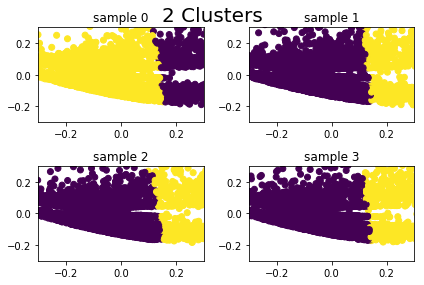

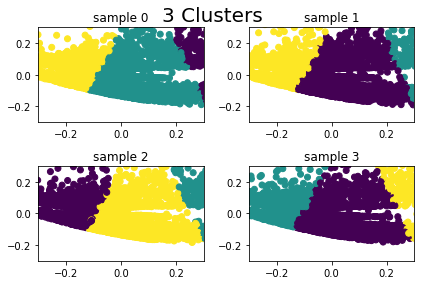

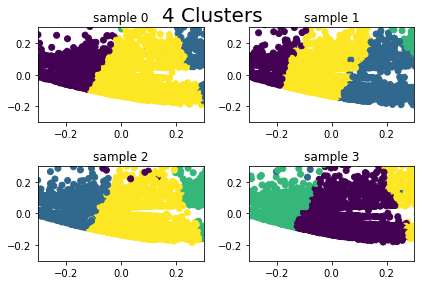

In [41]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred_km['pca_f1_sample{}'.format(i)]
        y_sub = ypred_km['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred_km['{}cluster_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [42]:
score_km.sort_values(by='Silhouette Score', ascending=False)

,Cluster Prediction,Silhouette Score
0,2cluster_sample0,0.520243
6,2cluster_sample2,0.518975
9,2cluster_sample3,0.511967
3,2cluster_sample1,0.511543
11,4cluster_sample3,0.403919
8,4cluster_sample2,0.396235
10,3cluster_sample3,0.394622
2,4cluster_sample0,0.393771
4,3cluster_sample1,0.388122
7,3cluster_sample2,0.384824


The 2-cluster solution appears to be the most consistent across each sample, which is evidenced by visually inspecting the cluster plots. The silhouette scores also confirm this, since the 2-cluster samples had the highest silhouette scores.

# Mean Shift

29103
[[-0.05713569 -0.04622757]
 [ 0.44959411  0.12150904]
 [ 0.1000767   0.67355577]
 [ 0.36547378  0.49955628]]
Number of estimated clusters: 4


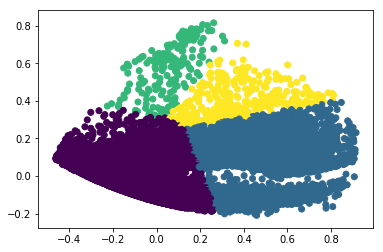

29103
[[-0.05376378 -0.03675659]
 [ 0.10551615  0.66120873]]
Number of estimated clusters: 2


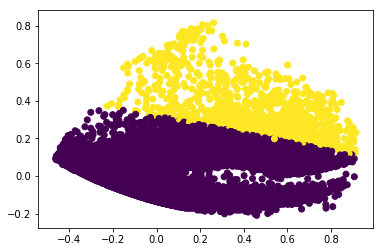

29103
[[-0.05635634 -0.03205666]
 [ 0.11239992  0.63758901]]
Number of estimated clusters: 2


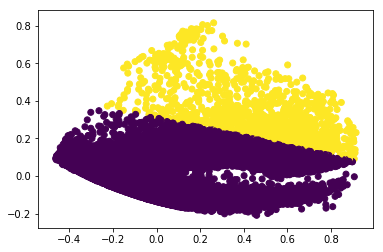

29103
[[-0.05650985 -0.0291582 ]
 [ 0.12439164  0.59941539]]
Number of estimated clusters: 2


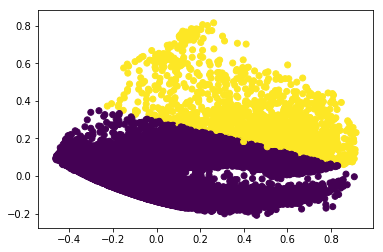

In [49]:
# Data frame to store features and predicted cluster memberships.
ypred_ms = pd.DataFrame()
score_ms = pd.DataFrame(columns=['Cluster Prediction', 'Quantile', 'Silhouette Score'])

for n in [0.1, 0.2, 0.3, 0.4]:
    # Here we set the bandwidth. This function automatically derives a bandwidth
    # number based on an inspection of the distances among points in the data.
    bandwidth = estimate_bandwidth(X_pca, quantile=n, n_samples=500)

    # Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

    pred = ms.fit(X_pca)

    # Extract cluster assignments for each data point.
    labels = ms.labels_

    print(len(labels))
    
    # Coordinates of the cluster centers.
    cluster_centers = ms.cluster_centers_

    print(cluster_centers)
    
    # Count our clusters.
    nclust = len(np.unique(labels))
    
    print("Number of estimated clusters: {}".format(nclust))
    
    cntrs = len(np.unique(labels))
    
    ypred_ms[str(cntrs) + 'cluster'] = pred
    
    silhouette_score_ms = metrics.silhouette_score(X_pca, labels, metric='euclidean')
    score_ms = score_ms.append({'Cluster Prediction': str(nclust) + 'cluster', 
                          'Silhouette Score':silhouette_score_ms, 'Quantile':n}, ignore_index=True)
    
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
    plt.show()

In [50]:
score_ms.sort_values(by='Silhouette Score', ascending=False)

,Cluster Prediction,Quantile,Silhouette Score
3,2cluster,0.4,0.560491
2,2cluster,0.3,0.557991
1,2cluster,0.2,0.556897
0,4cluster,0.1,0.532328


Mean shift generates the appropriate number of clusters for us, for a particular quantile. Once again, the 2-cluster solution turns out to be the best, with a quantile of 0.4.

# Spectral Clustering

In [51]:
# Data frame to store features and predicted cluster memberships.
ypred_sc = pd.DataFrame()
score_sc = pd.DataFrame(columns=['Cluster Prediction', 'Silhouette Score'])

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    #print(ypred)
    #print(len(data[1][:, 0]))
    #print(len(data[1][:, 1]))
    
    # Put the features into ypred.
    ypred_sc['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_sc['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        sc = SpectralClustering(n_clusters=nclust)
        pred = sc.fit_predict(data[0])
        ypred_sc[str(nclust) + 'cluster_sample' + str(counter)] = pred
        
        labels = sc.labels_
        silhouette_score_sc = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score_sc = score_sc.append({'Cluster Prediction': str(nclust) + 'cluster_sample' + str(counter), 
                                    'Silhouette Score':silhouette_score_sc}, ignore_index=True)

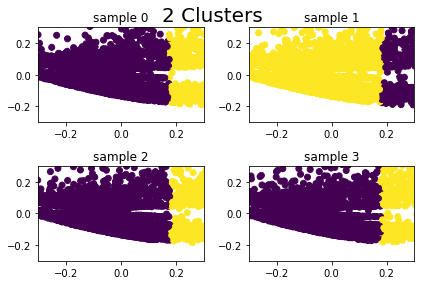

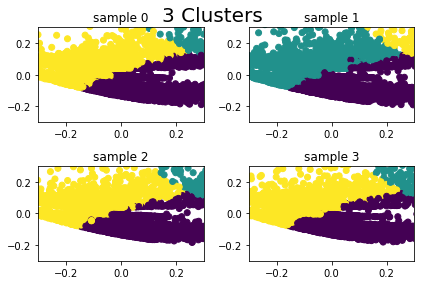

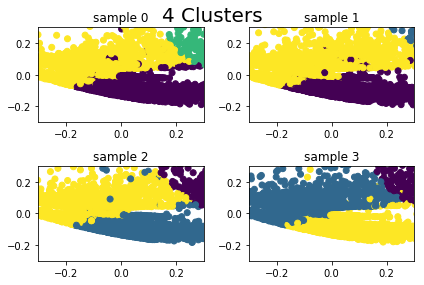

In [52]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred_sc['pca_f1_sample{}'.format(i)]
        y_sub = ypred_sc['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred_sc['{}cluster_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [53]:
score_sc.sort_values(by='Silhouette Score', ascending=False)

,Cluster Prediction,Silhouette Score
6,2cluster_sample2,0.533546
9,2cluster_sample3,0.530709
3,2cluster_sample1,0.530143
0,2cluster_sample0,0.526534
10,3cluster_sample3,0.358296
1,3cluster_sample0,0.356823
11,4cluster_sample3,0.355096
7,3cluster_sample2,0.354418
4,3cluster_sample1,0.352563
2,4cluster_sample0,0.352078


Spectral clustering closely mirrors the results from k-means and mean-shift, with the 2-cluster solution again being the most consistent across samples. The 2-cluster samples also received the highest silhouette scores, with each scoring above 0.5.

# Affinity Propagation

Estimated number of clusters: 1650


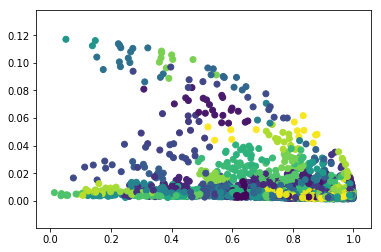

Estimated number of clusters: 2698


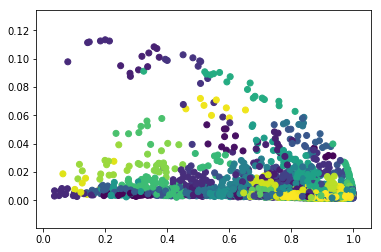

Estimated number of clusters: 2290


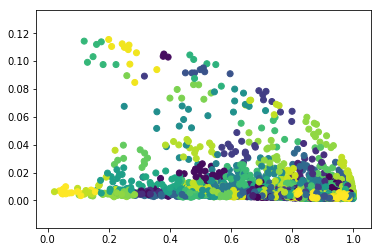

Estimated number of clusters: 2151


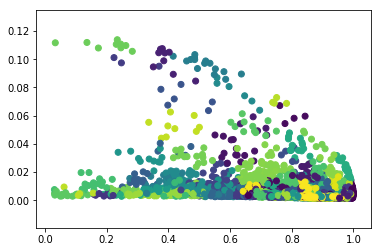

In [54]:
# Data frame to store features and predicted cluster memberships.
ypred_af = pd.DataFrame()
score_af = pd.DataFrame(columns=['Cluster Prediction', 'Silhouette Score'])

for counter, data in enumerate([X1, X2, X3, X4]):
    # Declare and fit the model.
    af = AffinityPropagation().fit(data)

    # Pull the number of clusters and cluster assignments for each data point.
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    labels = af.labels_

    print('Estimated number of clusters: {}'.format(n_clusters_))
        
    silhouette_score_af = metrics.silhouette_score(data, labels, metric='euclidean')
    score_af = score_af.append({'Cluster Prediction': str(n_clusters_) + 'cluster_sample' + str(counter), 
                              'Silhouette Score':silhouette_score_af}, ignore_index=True)
    
    plt.scatter(data[:, 0], data[:, 1], c=labels)
    plt.show()

In [55]:
score_af.sort_values(by='Silhouette Score', ascending=False)

,Cluster Prediction,Silhouette Score
0,1650cluster_sample0,0.184451
3,2151cluster_sample3,0.181178
2,2290cluster_sample2,0.152143
1,2698cluster_sample1,0.145398


Affinity propagation tends to overestimate the number of clusters, as we can see. All four cluster predictions are absurdly high, with a 1650-cluster solution achieving the highest silhouette score, at only 0.184.

0.5202428345413108
0.38098843534028
0.39377122916097657
0.367659815727537
0.3880136471641741
0.4043889766364271
0.39852719089575067
0.3764213616337956
0.38122271829155424
0.3763719727694299
0.39733364581392855
0.3994546367386991
0.400102697751794


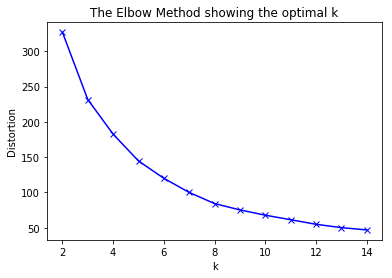

In [58]:
# k means determine k
distortions = []
K = range(2,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X1)
    pred = kmeanModel.predict(X1)
    #pred = kmeanModel.predict(X1)
    #distortions.append(sum(np.min(cdist(X1, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X1.shape[0])
    distortions.append(kmeanModel.inertia_)
    print(metrics.silhouette_score(X1, kmeanModel.labels_, metric='euclidean'))
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method seems to report the optimal k as 3. However, K-means is highly sensitive to preprocessing, so this can explain the discrepancy.

Based upon the clustering plots above, of which 3 out of 4 indicated a 2-cluster solution as optimal, I can conclude that there are two main groups of runners in this dataset.